<h1> Implémentation du schéma de Rusanov - CAS 2D </h1>

Voici le code à partir duquel nous avons obtenu les graphes du rapport. Ce code permet aussi de générer des fichier .gif et ainsi de visualiser les évolutions (hauteur d'eau et débit) au cours du temps.

<h2>Équations dans le cas 2D :</h2>

$$ \frac{\partial h}{\partial t} + \frac{\partial hu}{\partial x} + \frac{\partial hv}{\partial y} = 0$$

$$ \frac{\partial hu}{\partial t} + \frac{\partial}{\partial x} ( hu^2 + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( huv + \frac{gh^2}{2} ) = 0$$

$$ \frac{\partial hv}{\partial t} + \frac{\partial}{\partial x} ( huv + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( hv^2 + \frac{gh^2}{2} ) = 0$$

## Importations

In [161]:
import math as math # Pour les fonctions math

import matplotlib.pyplot as plt # Pour l'affichage des graphes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits import mplot3d 

plt.rc('font', size=20)

import numpy as np # Pour les tableaux numpy
import imageio # Pour faire des .gif

## Paramètres du problème

In [162]:
g=1 # Constante gravitationnelle

xMin=0 # Bord gauche du domaine
xMax=100 # Bord droit du domaine

yMin = 0 #Bord bas du domaine
yMax = 100 #Bord haut du domaine

N=64 # Nombre de points (strictement à l'intérieur)
# Donc au total, on considère (N+2)^2 points avec les bords

h=(xMax-xMin)/(N+1) # Pas du maillage spatial, le même pour X et Y

Tmax=10 # Temps final de la simulation
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

## Conditions initiales et Topographie

Dans la cellule ci-dessous, nous définissons la discrétisation de l'axe des abscisses $\textbf{X}$, ainsi que la topographie $\textbf{Z}$ et les profils initiaux de la hauteur d'eau $h$ et du débit $q$. Le code en commentaire correspond à différentes initialisations possibles. Pour le suite, notons 
$\textbf{U}=
\begin{pmatrix}
   h \\
   q \\
\end{pmatrix}
\in\mathbb{R}^{2}$ 
le vecteur inconnu.

In [163]:
X,Y=np.mgrid[xMin:xMax+2*h/3:h,yMin:yMax+2*h/3:h] # Discrétisation de [xMin, xMax] et [yMin, yMax]
XY = X+Y*1j

W0 = np.ones([N+2,N+2]) # Discrétisation de h
W1 = np.ones([N+2,N+2]) # Discrétisation de hu
W2 = np.ones([N+2,N+2]) # Discrétisation de hv

# Définitions du h initial ------------------------------------

# Hauteur de l'eau en escalier 
# W0[0,0:(N+2)//3]   = 3
# W0[0,(N+2)//3:N+2] = 1.25

# Hauteur de l'eau constante
# W0[0,:]=1

# Hauteur de l'eau en bosse
W0 = 1+10/(5 + .01*( (X-50)**2 + (Y-50)**2 ) )


# Définitions du débit initial ------------------------------------

# Débit de l'eau constant
W1[:,:]=0
W2[:,:]=0

## Nombre de sauvegardes durant la simulation

Quelques variables qui vont nous servir pour enregistrer des étapes de la simulation, sans pour autant les sauvegarder toutes. Sans ça, le nombre d'images à sauver deviendrait vite trop important.

In [164]:
nSauvegarde=100 # Nombre de sauvegardes au cours de la simulation
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
j=0 # Nombre de sauvegardes déjà effectuées

## Affichage des images

La fonction ci-dessous permet de gérer l'affichage de la solution. Elle est suivie d'un test. Les graphes qui s'affichent sont ceux de $h$ et $q$ à $t=0$.

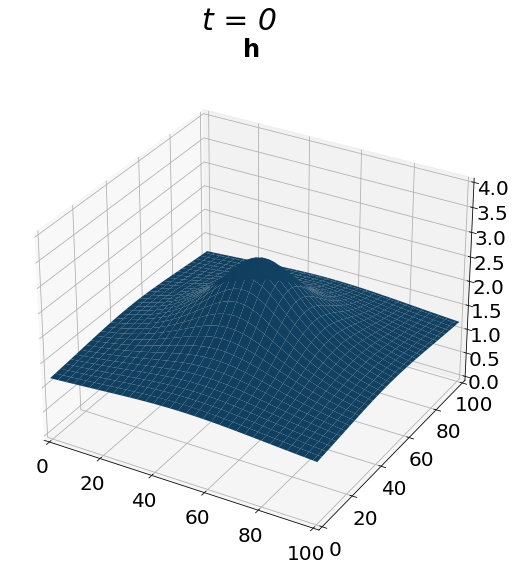

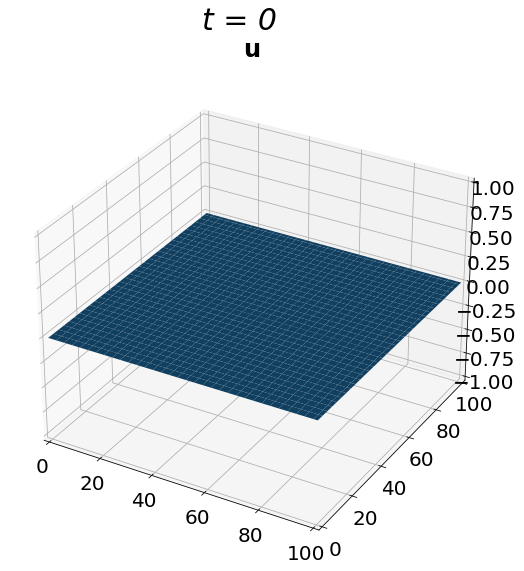

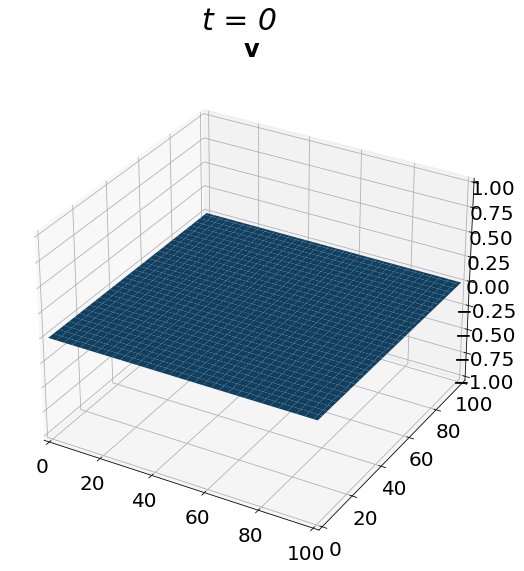

In [168]:
def affiche_W(t=0,index=0):
    
    #index : suivant que l'on veuille afficher h, u ou v
    
    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
        
    plt.show()
    
#Affichage de h, u et v
affiche_W()
affiche_W(index=1)
affiche_W(index=2)

## Sauvegarde des images

_enregistre_U_ effectue un traitement identique à _affiche_U_. La seule différence est qu'elle enregistre le plot dans le répertoire courant plutôt que de l'afficher.

In [6]:
def enregistre_W(t,index=0):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
      
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
    

    fig.canvas.draw()
    image_from_plot=np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot=image_from_plot.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    
    images.append(image_from_plot)
   
    plt.close()
    
enregistre_U(0,index=0)

<h2> Fonctions intervenant dans le schéma </h2>

En posant : $W = \left[ {\begin{array}{c}   h \\    hu \\    hv \\  \end{array} } \right] $ ; $ F(W) = \left[ {\begin{array}{c}   hu \\    hu^2 + \frac{gh^2}{2}  \\    huv + \frac{gh^2}{2} \\  \end{array} } \right] $ ; $ G(W) = \left[ {\begin{array}{c}   hv \\    huv + \frac{gh^2}{2}  \\    hv^2 + \frac{gh^2}{2} \\  \end{array} } \right] $ 

Avec $h$ la hauteur de l'eau, $u$ sa vitesse suivant la direction $x$ et $v$ sa vitesse suivant la direction $y$.

On a le système suivant :

$$ \frac{\partial W}{\partial t} + \frac{\partial F(W)}{\partial x} + \frac{\partial G(W)}{\partial y} = 0 $$

En identifiant $F(W)$ au flux suivant $x$ et $G(W)$ au flux suivant $y$.

En s'inspirant de ce qui a été fait dans le cas 1D, on discrétise de la manière suivante :

$$ \frac{ W_{i,j}^{n+1} - W_{i,j}^{n} }{\Delta t} + \frac{ F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} }{\Delta x} + \frac{F_{i,j+\frac{1}{2}}^{n} -  F_{i,j-\frac{1}{2}}^{n} }{\Delta y} = 0 $$

Ce qui nous donne finalement :

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( F_{i,j+\frac{1}{2}}^{n} -  F_{i,j-\frac{1}{2}}^{n} ) $$

Avec : 

$$ F_{i+\frac{1}{2},j} =  \frac{ F(W_{i+1,j}) + F(W_{i,j}) }{2} - c \frac{ W_{i+1,j} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i+1,j}} \sup_{k = 1,2} | \lambda _k(W) | $$

et

$$ F_{i,j+\frac{1}{2}} =  \frac{ F(W_{i,j+1}) + F(W_{i,j}) }{2} - c \frac{ W_{i,j+1} - W_{i,j} }{2} \quad avec \quad c = \sup_{W =  W_{i,j} ,  W_{i,j+1}} \sup_{k = 1,2} | \lambda _k(W) | $$


In [7]:
# Fonction F du schéma :
# Entrée : vecteurs w0 , w1 , w2 ( 3 numpy.ndarray chacun bi-dimensionnel)
# Sortie : F(W = [w0,w1,w2]) ( 3 numpy.ndarray chacun bidimensionnel)
def F(w0,w1,w2):
    return w1 , w1**2 / w0 + g * w0**2 / 2 , w1*w2/(w0**2) + g * w0**2

# Fonction qui retourne la valeur propre max en module
# Entrées : * h , hu et hv solution discrétisée ( 3 numpy.ndarray de taille (N+2)^2 )
#           * indices i et j de la position spatiale
# Sortie : max_j max_k |λ_k(W_j^n)|
def vmax(w0,w1,w2,i,j,direction):
    res = abs( W1[i,j]/W0[i,j] + math.sqrt(g*W0[i,j]))
    res = max(res,abs( W1[i,j]/W0[i,j] - math.sqrt(g*W0[i,j])))
    
    if(direction == 0): #Direction suivant les x

        res = max(res,abs( W1[i+1,j]/W0[i+1,j] + math.sqrt(g*W0[i+1,j])))
        res = max(res,abs( W1[i+1,j]/W0[i+1,j] - math.sqrt(g*W0[i+1,j])))
    
    elif(direction == 1): #Direction suivant les y
        
        res = max(res,abs( W1[i,j+1]/W0[i,j+1] + math.sqrt(g*W0[i,j+1])))
        res = max(res,abs( W1[i,j+1]/W0[i,j+1] - math.sqrt(g*W0[i,j+1])))

    return res

# Fonction flux numérique :
# Entrées : * U solution discrétisée (type numpy.ndarray de taille 2*(N+2))
#           * indice i de la position spatiale
# Sortie : F_{i+1/2}^n
def F_ronde(W,i,j):
    return (F(U[:,i])+F(U[:,i+1]))/2-vmax(U,i)*(U[:,i+1]-U[:,i])/2

## Boucle de résolution numérique

Une fois le pas de temps $\Delta t^n$ déterminé selon le critère qui garanti le respect de la conditions CFL, on passe du temps $t^n$ au temps $t^{n+1}$ suivant la relation explicite suivante :

$$\textbf{U}_i^{n+1}=\textbf{U}_i^{n}-\Delta t^n\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \Delta t^n\mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}+\Delta t^n \begin{pmatrix}
0 \\
-gh_i \frac{Z_{i+1}-Z_{i-1}}{2\Delta x_i}\\
\end{pmatrix}$$

In [8]:
while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = vmax(U, 0)
    for i in range(1, N+1):
        M = max(M, vmax(U, i))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(1, N+1):
        Uprime[:,i] = U[:,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))
        Uprime[:,i] -= tau*B(U[:,i],i)
        
    U = Uprime
    
    # Conditions aux bords
    U[:,0] = U[:,1]
    U[:,N+1] = U[:,N]

    t+=tau
    n+=1
    
    if (t > Tmax/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))
imageio.mimsave('movie.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 269
Gif Sauvegardé dans le dossier sous le nom : movie.gif
